<a href="https://colab.research.google.com/github/Lirikman/neural_networks/blob/main/practical_tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача 1. Обнаружение фальшивых новостей

Импортируем необходимые библиотеки

In [ ]:
!pip install scikit-learn==1.3.1

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn import svm
import time

### Загрузка данных

Загрузим готовый датасет с реальными и фейковыми новостями, и на его основе построим модель класса машинного обучения  используя библиотеку sklearn, а также обучим модель отличать реальные новости от фейковых.

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/practica/fake_news.csv # загружаем данные

--2025-01-08 07:00:59--  https://storage.yandexcloud.net/academy.ai/practica/fake_news.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30696129 (29M) [text/csv]
Saving to: ‘fake_news.csv’

fake_news.csv       100%[===================>]  29.27M  13.1MB/s    in 2.2s    

2025-01-08 07:01:02 (13.1 MB/s) - ‘fake_news.csv’ saved [30696129/30696129]



In [ ]:
df = pd.read_csv("./fake_news.csv") # wget скачал в рабочую директорию файл с датасетом и мы его уже можем использовать

Проверяем всё ли загрузилось:

In [ ]:
print(df.head(5))

   Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  


 Посмотрим информацию о загруженном датасете:

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB
None


Из полученной информации видно, что датасет состоит и 6335 строк, и 4 колонок - #, tilte, text, label.

Благодаря тому, что данные уже были подготовлены, предварительной обработки они не требуют.

### Определение признаков и меток

Теперь нужно определить признаки (входные данные) и метки (выходные данные). С библиотекой Pandas можно легко «нарезать» таблицу и выбрать определённые строки/столбцы:

In [ ]:
X = df['title'] + '. ' + df['text'] # Объединим колонки Заголовок + Текст
y = df['label'] # Выберем только последнюю колонку

После того, как мы выбрали нужные признаки и метки, их можно разделить на тренировочные и тестовые наборы, используя функцию train_test_split():

In [ ]:
# test_size показывает, какой объем данных нужно выделить для тестового набора
# Random_state — просто сид для случайной генерации
# Этот параметр можно использовать для воссоздания определённого результата:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=27)

Чтобы убедиться в правильности обработки данных, выведем их и посмотрим:

In [ ]:
print(X_train)
print(y_train)

4239    US/Russian Relations Sour Further As Putin Ref...
4824    Dem outcry on abortion measure they failed to ...
1110    The Latest ABC/WaPo Poll Has the Hillary Campa...
2381    Hillary Clinton Wants a Strong Russia. Wait, w...
3655    Why Isn’t NSA Surveillance an Election Issue?....
                              ...                        
5413    The media needs to stop telling this lie about...
4848    Election Heats Up: Kerry Heads To The Poles…In...
3912    Insider Leaks Bill’s 2-Word Nickname For Hilla...
3768    Poll: Trump Reaches 50 Percent Support Nationa...
5139    American democracy is doomed. America's consti...
Length: 5068, dtype: object
4239    FAKE
4824    REAL
1110    FAKE
2381    FAKE
3655    FAKE
        ... 
5413    REAL
4848    FAKE
3912    FAKE
3768    REAL
5139    REAL
Name: label, Length: 5068, dtype: object


Рассчитаем сколько всего Реальных и Фейковых новостей содержится в датасете, для это создадим отдельный датафрейм с колонками 'label' и 'quantity', и выведем полученную информацию:

In [ ]:
df_count = pd.DataFrame(columns=['label', 'quantity'])
df_count['label'] = df['label'].unique().tolist()
df_count['quantity'] = df_count['label'].apply(lambda x: df[(df['label'] == x)].shape[0])
print(df_count.head())

  label  quantity
0  FAKE      3164
1  REAL      3171


По результатм расчёта видно что Фэйковых новостей - 3164 шт, а Реальных - 3171 шт, из чего можно сделать вывод что данные хорошо сбалансированы.

Для большей наглядности построим гистограмму с колиеством новостей по меткам:

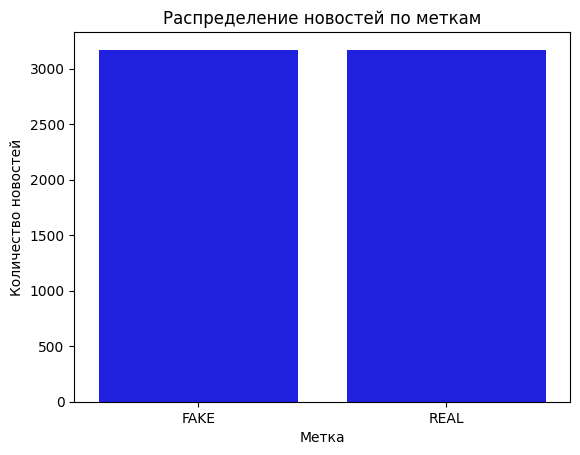

In [ ]:
sns.barplot(
    x='label',
    y='quantity',
    data=df_count,
    color='blue',)
plt.xlabel('Метка')
plt.ylabel('Количество новостей')
plt.title('Распределение новостей по меткам')
plt.show()

Все данные представлены в текстовом виде, а для обучения модели необходимо преобразовать данные в числовые векторы. Для это воспользуемся методом Term Frequency-Inverse Document Frequency (TF-IDF).

Перед применением TF-IDF к текстовым данным, часто полезно провести предварительную обработку данных. Одним из широко распространенных шагов является удаление стоп-слов - слов, которые не несут смысловой нагрузки (например, предлоги, союзы) и специальных символов.

In [ ]:
# Загрузка стоп-слов и пунктуации
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('russian'))
punctuation = set(string.punctuation)

def preprocess_text(text):
    words = word_tokenize(text.lower())  # Привести к нижнему регистру и токенизировать
    filtered_words = [word for word in words if word not in stop_words and word not in punctuation]
    return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Удаление стоп-слов из тренировочного набора и приведение к нижмену регистру
X_train = X_train.apply(preprocess_text)

Проверим полученный результат после обработки текста:

In [ ]:
print(X_train)

4239    us/russian relations sour further as putin ref...
4824    dem outcry on abortion measure they failed to ...
1110    the latest abc/wapo poll has the hillary campa...
2381    hillary clinton wants a strong russia wait wha...
3655    why isn ’ t nsa surveillance an election issue...
                              ...                        
5413    the media needs to stop telling this lie about...
4848    election heats up kerry heads to the poles…in ...
3912    insider leaks bill ’ s 2-word nickname for hil...
3768    poll trump reaches 50 percent support national...
5139    american democracy is doomed america 's consti...
Length: 5068, dtype: object


In [ ]:
# Преобразование текстовых данных в матрицу TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

### Создание и обучение модели

Построим несколько регрессионных моделей.

**1. Логистическая регрессия**

Обучим модель и рассчитаем время выполнения операции:

In [ ]:
model = LogisticRegression()
start = time.time()
model.fit(X_train_tfidf, y_train)
end = time.time()
LR_train_time = end - start
print(f"Logistic Regression Training Time: {LR_train_time:.2f} seconds")

Logistic Regression Training Time: 3.19 seconds


Рассчитаем точность модели:

In [ ]:
# Предсказание категорий для тестовых данных
y_pred = model.predict(X_test_tfidf)
# Оценка точности модели
accuracy_LR = accuracy_score(y_test, y_pred)
print(f'Точность модели: {accuracy_LR:.2f}')

Точность модели: 0.93


Модель отлично справляется с классификацией новостей в обучающем наборе данных. Теперь проверим точность модели по меткам.

In [ ]:
print("Точность с разбивкой по меткам :")
print("---------------------------")
label_accs = {}
unique_labels = y_test.unique()

for label in unique_labels:
  label_ind = (y_test == label)
  # extract predictions for specific true label
  pred_label = model.predict(X_test_tfidf[label_ind])
  labels = y_test[label_ind]
  # compute class-wise accuracy
  label_accs[accuracy_score(labels, pred_label)] = label
for key in sorted(label_accs):
  print(f"Метка {label_accs[key]}: {key:.3f}")

Точность с разбивкой по меткам :
---------------------------
Метка REAL: 0.906
Метка FAKE: 0.945


Видно, что модель немного хуже определяет Реальные новости, чем Фейковые.

Посмотрим на первые 5 новостей, где предсказания модели не совпали с метками:

In [ ]:
errors = X_test[(y_pred != y_test)]
print(errors.head(5))

3653    Clinton Foundation will continue to accept for...
1812    Hillary Clinton Attacks Donald Trump for Threa...
3217    Gay man finds it in himself to tolerate religi...
893     Public vs. Media on War. Email \nA new poll fr...
3438    President Obama Gets Real, Not Revenge, On Rep...
dtype: object


Построим кривую ROC – график, который иллюстрирует производительность классификационной модели при всех возможных порогах классификации. Ось X данного графика представляет собой FPR, т.е ложноположительную частоту, а ось Y — TRP, т.е истинноположительную частоту.


Также рассчитаем показатель AUC (Area Under the ROC Curve) — это мера, которая позволяет суммировать производительность модели одним числом, измеряя площадь под кривой ROC. AUC колеблется от 0 до 1, где более высокое значение AUC указывает на более высокую производительность модели. AUC равный 0.5 указывает на отсутствие дискриминационной способности модели, тогда как AUC равный 1.0 означает идеальное различие классов.

In [ ]:
# предсказание вероятностей
y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]

# расчитываем TPR и FPR, используя функцию roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label='REAL')
auc_lr = roc_auc_score(y_test, y_pred_proba)

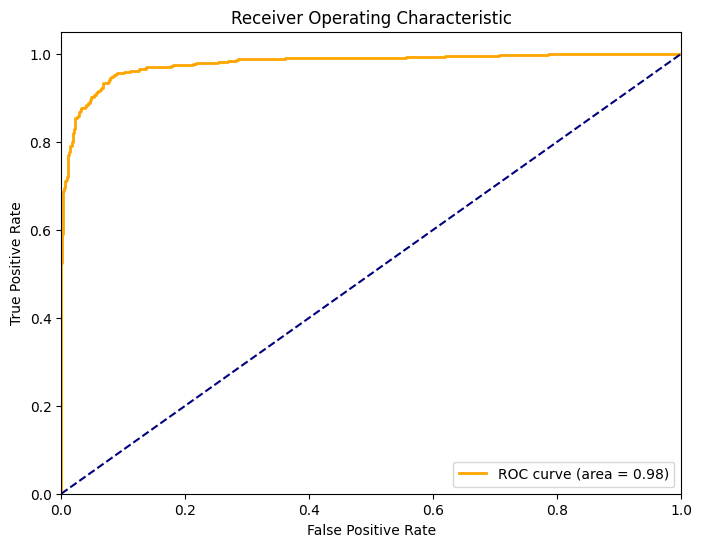

In [ ]:
# построение ROC кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % auc_lr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

Из расчётов видно, что производительность модели составляет 98%

Построим матрицу ошибок и оценим качество классификации

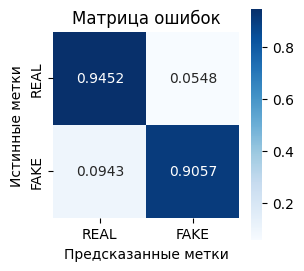

In [ ]:
def show_confusion_matrix(test_labels, test_classes):
  # Вычисление матрицы ошибок и ее нормализация
  plt.figure(figsize=(3,3))
  confusion = confusion_matrix(test_labels, test_classes)
  confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
  axis_labels = unique_labels
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title("Матрица ошибок")
  plt.ylabel("Истинные метки")
  plt.xlabel("Предсказанные метки")

show_confusion_matrix(y_test, y_pred)

**2. Комплементарный наивный байесовский классификатор**

Обучим модель и рассчитаем время затраченное на операцию обучения:

In [ ]:
compl_ml = ComplementNB()
start = time.time()
compl_ml.fit(X_train_tfidf, y_train)
end = time.time()
CNB_train_time = end - start
print(f"ComplementNB Training Time: {CNB_train_time:.2f} seconds")

ComplementNB Training Time: 0.06 seconds


Рассчитаем точность модели:

In [ ]:
# Предсказание категорий для тестовых данных
y_pred = compl_ml.predict(X_test_tfidf)
# Оценка точности модели
accuracy_CNB = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy_CNB:.2f}")

Точность модели: 0.83


In [ ]:
print("Точность с разбивкой по меткам :")
print("---------------------------")
label_accs = {}
unique_labels = y_test.unique()

for label in unique_labels:
  label_ind = (y_test == label)
  # extract predictions for specific true label
  pred_label = compl_ml.predict(X_test_tfidf[label_ind])
  labels = y_test[label_ind]
  # compute class-wise accuracy
  label_accs[accuracy_score(labels, pred_label)] = label
for key in sorted(label_accs):
  print(f"Метка {label_accs[key]}: {key:.3f}")

Точность с разбивкой по меткам :
---------------------------
Метка FAKE: 0.674
Метка REAL: 0.986


Видно, что модель испытывает трудности с определением Фейковых новостей - 67% точности, гораздо лучше модель определяет реальные новости - 98% точности.

Выведем первые 5 новостей предсказания модели которых не совпали с метками:

In [ ]:
errors = X_test[(y_pred != y_test)]
print(errors.head(5))

3700    Healthcare system bleeds us dry by design. Lic...
1787    Teachers Strike Allowing Children To Sample Th...
463     The Middle East Crises Trump Inherits Could St...
2940    US-backed Forces Launch Raqqa Offensive as Ter...
509     CAN'T TRUST OBAMA! Look At Sick Thing He Just ...
dtype: object


Построим кривую ROC и рассчитаем показатель AUC:

In [ ]:
# предсказание вероятностей
y_pred_proba = compl_ml.predict_proba(X_test_tfidf)[:, 1]

# расчитываем TPR и FPR, используя функцию roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label='REAL')
auc_CNB = roc_auc_score(y_test, y_pred_proba)

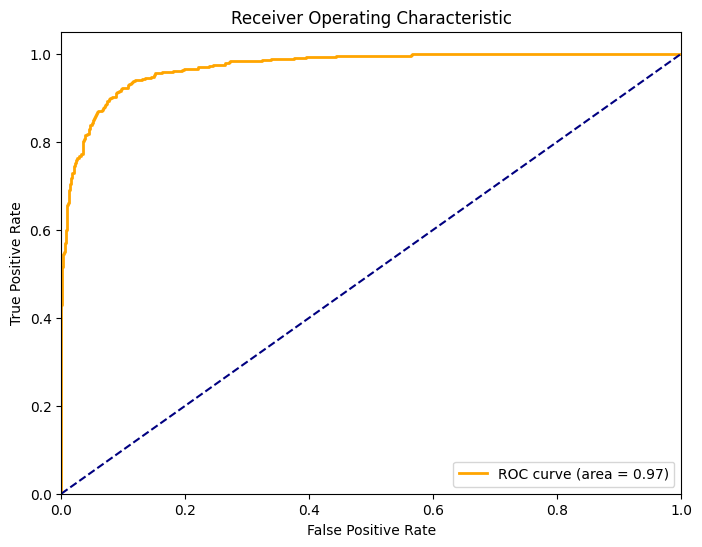

In [ ]:
# построение ROC кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % auc_CNB)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

Из построенного графика видно, что производительность модели составляет 97%

Построим матрицу ошибок и оценим качество классификации

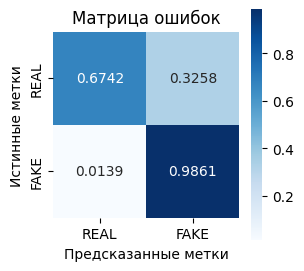

In [ ]:
def show_confusion_matrix(test_labels, test_classes):
  # Вычисление матрицы ошибок и ее нормализация
  plt.figure(figsize=(3,3))
  confusion = confusion_matrix(test_labels, test_classes)
  confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
  axis_labels = unique_labels
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title("Матрица ошибок")
  plt.ylabel("Истинные метки")
  plt.xlabel("Предсказанные метки")

show_confusion_matrix(y_test, y_pred)

**3. Метод опорных векторов**

Обучим модель и рассчитаем время выполнения операции обучения:

In [ ]:
SVC_model = svm.SVC()
start = time.time()
SVC_model.fit(X_train_tfidf, y_train)
end = time.time()
SVC_train_time = end - start
print(f"Support Vector Machines Training Time: {SVC_train_time:.2f} seconds")

Support Vector Machines Training Time: 59.79 seconds


Рассчитаем точность модели:

In [ ]:
# Предсказание категорий для тестовых данных
SVC_prediction = SVC_model.predict(X_test_tfidf)
# Оценка точности модели
accuracy_SVC = accuracy_score(SVC_prediction, y_test)
print(f"Точность модели: {accuracy_SVC:.2f}")

Точность модели: 0.95


In [ ]:
print("Точность с разбивкой по меткам :")
print("---------------------------")
label_accs = {}
unique_labels = y_test.unique()

for label in unique_labels:
  label_ind = (y_test == label)
  # extract predictions for specific true label
  pred_label = SVC_model.predict(X_test_tfidf[label_ind])
  labels = y_test[label_ind]
  # compute class-wise accuracy
  label_accs[accuracy_score(labels, pred_label)] = label
for key in sorted(label_accs):
  print(f"Метка {label_accs[key]}: {key:.3f}")

Точность с разбивкой по меткам :
---------------------------
Метка REAL: 0.929
Метка FAKE: 0.969


Видно что модель лучше распознаёт Фейковые новости - 96% точности, немного хуже модель определяет Реальные новости - 92% точности.

Выведем первые 5 новостей предсказания модели по которым не совпали с метками:

In [ ]:
errors = X_test[(SVC_prediction!= y_test)]
print(errors.head(5))

3653    Clinton Foundation will continue to accept for...
1812    Hillary Clinton Attacks Donald Trump for Threa...
893     Public vs. Media on War. Email \nA new poll fr...
3438    President Obama Gets Real, Not Revenge, On Rep...
2150    FBI’s brazen terrorism lie: What the Boston Ma...
dtype: object


Построим кривую ROC и рассчитаем показатель AUC:

In [ ]:
# предсказание вероятностей
y_decision_func = SVC_model.decision_function(X_test_tfidf)

# расчитываем TPR и FPR, используя функцию roc_curve
fpr, tpr, _ = roc_curve(y_test, y_decision_func, pos_label='REAL')
auc_SVC = roc_auc_score(y_test, y_decision_func)

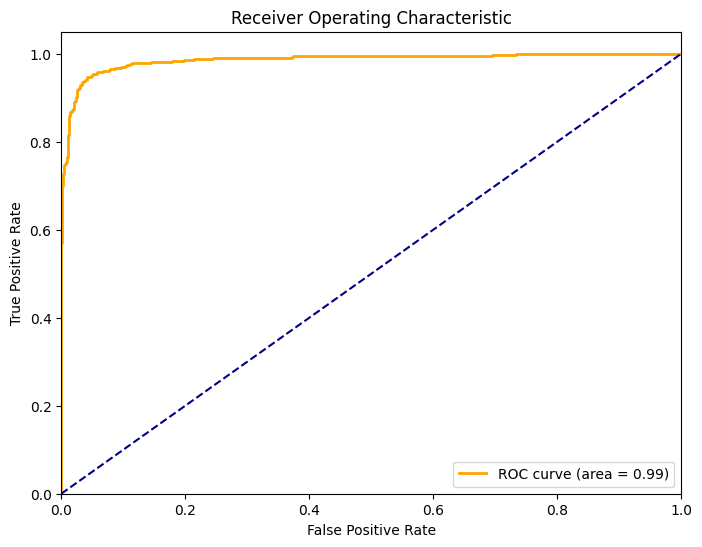

In [ ]:
# построение ROC кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % auc_SVC)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

Из построенного графика видно, что производительность модели составляет 99%

Построим матрицу ошибок и оценим качество классификации

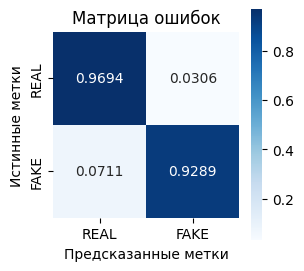

In [ ]:
def show_confusion_matrix(test_labels, test_classes):
  # Вычисление матрицы ошибок и ее нормализация
  plt.figure(figsize=(3,3))
  confusion = confusion_matrix(test_labels, test_classes)
  confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
  axis_labels = unique_labels
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title("Матрица ошибок")
  plt.ylabel("Истинные метки")
  plt.xlabel("Предсказанные метки")

show_confusion_matrix(y_test, SVC_prediction)

### Оценка алгоритмов

Построим диаграмму распределения точности модели в зависимости от выбранного алгоритма

In [ ]:
df_accuracy = pd.DataFrame(columns=['algorithm', 'accuracy']) #  создадим ноый датафрейм с колонками алгоритм и качество

In [ ]:
# Заполним датафрейм данными
df_accuracy['algorithm'] = ['LogisticRegression', 'SVC', 'ComplementNB']
df_accuracy['accuracy'] = [accuracy_LR, accuracy_SVC, accuracy_CNB]

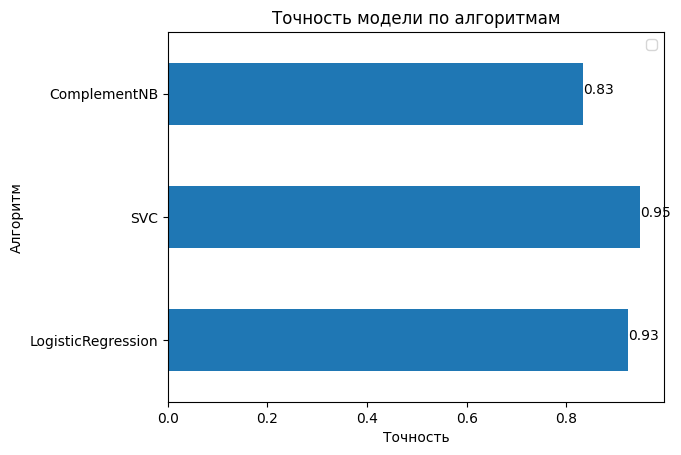

In [ ]:
# Построим гистограмму
df_accuracy.set_index('algorithm').plot(kind='barh', stacked=True)
plt.title('Точность модели по алгоритмам')
plt.ylabel('Алгоритм')
plt.xlabel('Точность')
# Отобразим значения данных на графике
for index, value in enumerate(df_accuracy['accuracy']):
    plt.text(value, index, str(round(value, 2)), ha='left')
plt.legend('')
plt.show()

Из построенной диаграммы видно, что самая высокая точность обучения модели при  алгоритме SVC (95%), на втором месте LogisticRegression (93%), а наименьшая точность обучения модели - ComplementNB (83%).

Оценим время выполнения процесса обучения в зависимости от алгоритма

In [ ]:
df_time = pd.DataFrame(columns=['algorithm', 'time']) #  создадим ноый датафрейм с колонками алгоритм и время

In [ ]:
# Заполним датайрейм данными
df_time['algorithm'] = ['LogisticRegression', 'SVC', 'ComplementNB']
df_time['time'] = [LR_train_time, SVC_train_time, CNB_train_time]

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Bar(
    x=df_time['time'],
    y=df_time['algorithm'],
    orientation='h',
))

fig.update_layout(
    autosize=False,
    width=1500,
    height=500,
    title="Время обучения модели по алгоритмам",
    xaxis = dict(
        title=dict(
            text="Время обучения модели",
            font=dict(
            size=15
            )
        ),
        ticktext=["0s", "2s", "5s", "10s", "20s", "30s", "60s"],
        tickvals=[0, 2, 5, 10, 20, 30, 60],
        tickmode="array",
    ),
    yaxis_title="Алгоритм обучения",
)

fig.update_xaxes(automargin=True)

fig.show()

Из построенного графика видно что быстрее всего модель обучается по алгоритму Комплементарного наивного байесовского классификатора - 0,03 сек, на втором месте Алгоритм логистической регресии - 1,97 сек., и на последнем месте Метод опорных векторов - 57,5 сек.

Оценим производительность модели по показателю AUC, при различных алгоритмах обучения

In [ ]:
df_auc = pd.DataFrame(columns=['algorithm', 'auc']) # создание датайрейма с колонками алгоритм и показатель производительности auc

In [ ]:
# Заполним датайрейм данными
df_auc['algorithm']=['LogisticRegression', 'ComplementNB', 'SVC']
df_auc['auc']=[auc_lr, auc_CNB, auc_SVC]

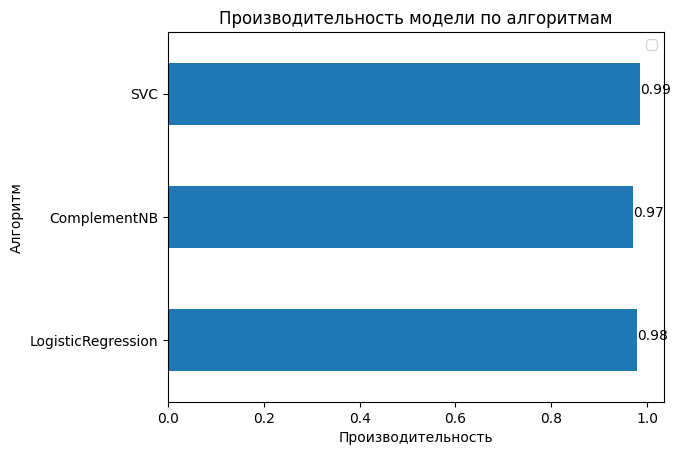

In [ ]:
# Построим гистограмму
df_auc.set_index('algorithm').plot(kind='barh', stacked=True)
plt.title('Производительность модели по алгоритмам')
plt.ylabel('Алгоритм')
plt.xlabel('Производительность')
# Отобразим значения данных на графике
for index, value in enumerate(df_auc['auc']):
    plt.text(value, index, str(round(value, 2)), ha='left')
plt.legend('')
plt.show()

По построенной диаграмме можно сделать вывод о том, что самая высокая производительность модели при алгоритме SVC - 99%, на втором месте LogisticRegression - 98%, самая маленькая производительность при ComplemetnNB- 97%.

### ВЫВОД: Для построения модели класса машинного обучения по выявлению Фальшивых новостей лучше всего подошёл Метод опорных векторов (Support Vector Machines - SVM), точность модели 95%, но уступающий по сокрости выполнения алгоритмам Логистической регресии (Logistic Regression), точность модели - 93%, и Комплиментарного наивного байесовского классификатора, точность модели - 83%.

# Задача 2. Обнаружение болезни паркинсона с помощью XGBoost

### Загрузка данных

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/practica/parkinsons.data # загружаем данные

--2025-01-08 10:29:46--  https://storage.yandexcloud.net/academy.ai/practica/parkinsons.data
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40697 (40K) [application/x-www-form-urlencoded]
Saving to: ‘parkinsons.data.1’

parkinsons.data.1   100%[===================>]  39.74K   260KB/s    in 0.2s    

2025-01-08 10:29:47 (260 KB/s) - ‘parkinsons.data.1’ saved [40697/40697]



Разметка в текстовом файле parkinsons.data такая же как и в файлах .csv, поэтому мы легко её сможем прочитать с помощью pandas:

In [ ]:
df_parkinson = pd.read_csv("./parkinsons.data") # читаем данные

Посмотрим информацию о файле:

In [ ]:
df_parkinson.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

Из полученной информации видно что датасет содержит 195 записей биомедицинских голосовых измерений пациентов, для определения людей с болезнью паркинсона и здоровых. Столбец status показывает болен ли пациент (значение 1) или здоров (значение 0).
В датасете всего 24 колонки.

| Столбец               | Описание                                                                 |
|-----------------------|-------------------------------------------------------------------------|
| name | Имя субъекта |
| MDVP:Fo(Hz) | Средняя основная частота вокала |
| MDVP:Fhi(Hz) | Максимальная основная частота вокала |
| MDVP:Flo(Hz) | Минимальная основная частота вокала |
| MDVP:Jitter(%) | Некоторая мера изменения основной частоты |
| MDVP:Jitter(Abs) | Некоторая мера изменения основной частоты |
| MDVP:RAP | Некоторая мера изменения основной частоты |
| MDVP:PPQ | Некоторая мера изменения основной частоты |
| Jitter:DDP | Некоторая мера изменения основной частоты |
| MDVP:Shimmer | Некоторая мера изменения амплитуды |
| MDVP:Shimmer(dB) | Некоторая мера изменения амплитуды |
| Shimmer:APQ3 | Некоторая мера изменения амплитуды |
| Shimmer:APQ5 | Некоторая мера изменения амплитуды |
| MDVP:APQ | Некоторая мера изменения амплитуды |
| Shimmer:DDA | Некоторая мера изменения амплитуды |
| NHR | Мера соотношения шума и тональных компонентов в голосе |
| HNR | Мера соотношения шума и тональных компонентов в голосе |
| status | Состояние здоровья субъекта (1) - болезнь Паркинсона, (0) - здоров |
| RPDE | Нелинейная динамическая мера сложности |
| DFA | Экспонента масштабирования фрактала сигнала |
| spread1 | Нелинейная мера изменения основной частоты |
| spread2 | Нелинейная мера изменения основной частоты |
| D2 | Нелинейная динамическая мера сложности |
| PPE | Нелинейная мера изменения основной частоты |

Посмотрим как выглядят первые 5 записей датасета:

In [ ]:
df_parkinson.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


Рассчитаем какое количество субъектов с болезнью паркинсона, а какое количество субъектов здоровых, в датасете. Для этого создадим новый датайфрейм, с колонками  status и quantity.

In [ ]:
df_count_parkinson = pd.DataFrame(columns=['status', 'quantity'])
df_count_parkinson['status'] = df_parkinson['status'].unique().tolist()
df_count_parkinson['quantity'] = df_count_parkinson['status'].apply(lambda x: df_parkinson[(df_parkinson['status'] == x)].shape[0])
print(df_count_parkinson.head())

   status  quantity
0       1       147
1       0        48


Для наглядности визуализируем полученный результат:

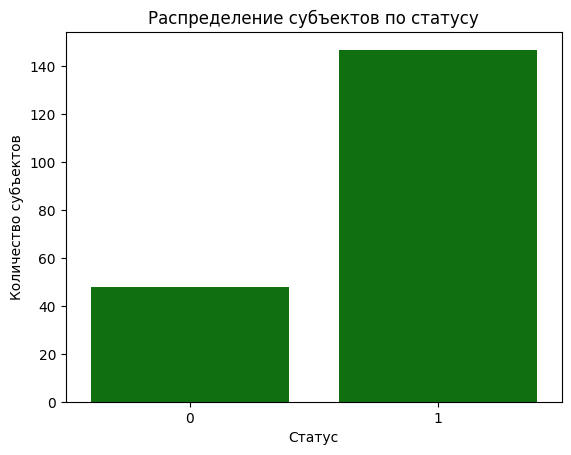

In [ ]:
sns.barplot(
    x='status',
    y='quantity',
    data=df_count_parkinson,
    color='green',)
plt.xlabel('Статус')
plt.ylabel('Количество субъектов')
plt.title('Распределение субъектов по статусу')
plt.show()

Из полученных результатов видно, что датасет содержит записи о 147 субъектах с болезнью паркинсона, а 48 субъектах - здоровых.
Вывод: данные не сбалансированны.
Для качественного обучения модели данные необходимо будем сбалансировать.

### Определение признаков и меток

Все столбцы в файле, кроме первого (name) являются числовыми - это признаки.

Столбец с метками это status: 0 (отсутствие болезни) или 1 (наличие).

In [ ]:
X = df_parkinson.drop(['name', 'status'], axis=1) # удаляем столбцы name, status
y = df_parkinson['status'] # выбираем только столбец status

При помощи train_test_split из модуля model_selection библиотеки scikit-learn  разделяем массивы «X» и «y» на тренировочные и тестовые наборы данных (в данном случае 20% от общего объема).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [ ]:
from imblearn.over_sampling import SMOTE

# Для балансировки данных используем метод увеличение выборки - Oversampling
oversampler = SMOTE()
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

Далее необходимо нормализовать признаки так, чтобы конечные значения находились в интервале от -1 до 1. Для этого применим MinMaxScaler из библиотеки sklearn:

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((-1, 1))
X_resampled = scaler.fit_transform(X_resampled)
X_test = scaler.transform(X_test)

### Создание и обучение модели

In [ ]:
!pip install --upgrade xgboost # установка библиотеки XGBoost

In [ ]:
import xgboost as xgb
classifier_model = xgb.XGBClassifier(eta = 0.02,
                                     colsample_bylevel = 0.6,
                                     colsample_bytree = 0.8,
                                     learning_rate = 0.8,
                                     subsample=0.6,
                                     seed = 15)
classifier_model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.6, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.02, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.8, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Предсказание категорий для тестовых данных
classifier_model_pred = classifier_model.predict(X_test)
# Оценка точности модели
print(f"Точность модели: {accuracy_score(y_test, classifier_model_pred):.2f}")

Точность модели: 0.97


In [ ]:
print("Точность с разбивкой по меткам :")
print("---------------------------")
label_accs = {}
unique_labels = y_test.unique()

for label in unique_labels:
  label_ind = (y_test == label)
  # extract predictions for specific true label
  pred_label = classifier_model.predict(X_test[label_ind])
  labels = y_test[label_ind]
  # compute class-wise accuracy
  label_accs[accuracy_score(labels, pred_label)] = label
for key in sorted(label_accs):
  print(f"Метка {label_accs[key]}: {key:.3f}")

Точность с разбивкой по меткам :
---------------------------
Метка 1: 0.969
Метка 0: 1.000


Видно что модель отлично распознаёт събуектов с болезнью паркинсона - 100% точности, а здоровых субъектов определяет в 96% случаев.

Построим кривую ROC – график, который иллюстрирует производительность классификационной модели при всех возможных порогах классификации. Ось X данного графика представляет собой FPR, т.е ложноположительную частоту, а ось Y — TRP, т.е истинноположительную частоту.


Также рассчитаем показатель AUC (Area Under the ROC Curve) — это мера, которая позволяет суммировать производительность модели одним числом, измеряя площадь под кривой ROC. AUC колеблется от 0 до 1, где более высокое значение AUC указывает на более высокую производительность модели. AUC равный 0.5 указывает на отсутствие дискриминационной способности модели, тогда как AUC равный 1.0 означает идеальное различие классов.

In [ ]:
# предсказание вероятностей
y_pred_proba = classifier_model.predict_proba(X_test)[:, 1]

# расчитываем TPR и FPR, используя функцию roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_Class_ML = roc_auc_score(y_test, y_pred_proba)

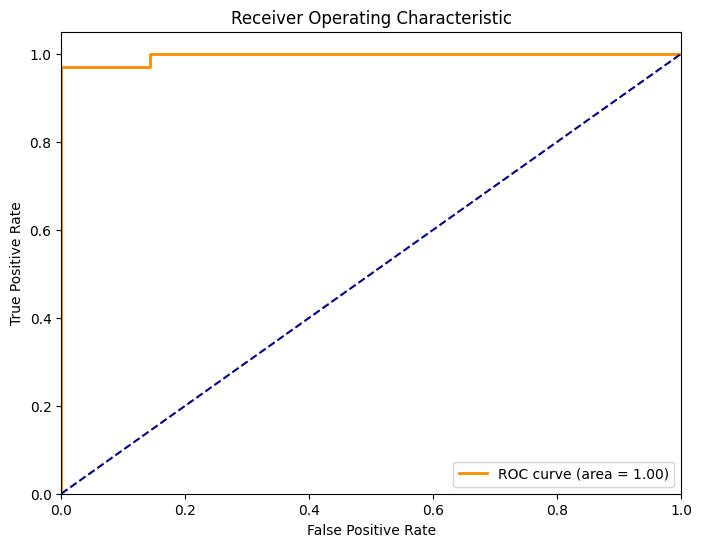

In [ ]:
# построение ROC кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_Class_ML)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

Из построенного графика видно хорошую производительность модели - 100%.

Построим матрицу ошибок и оценим качество классификации:

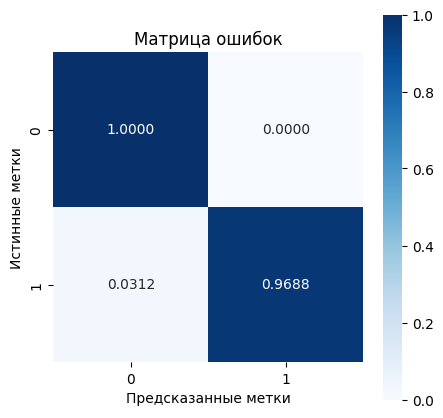

In [ ]:
def show_confusion_matrix(test_labels, test_classes):
  # Вычисление матрицы ошибок и ее нормализация
  plt.figure(figsize=(5,5))
  confusion = confusion_matrix(test_labels, test_classes)
  confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
  axis_labels = unique_labels
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title("Матрица ошибок")
  plt.ylabel("Истинные метки")
  plt.xlabel("Предсказанные метки")

show_confusion_matrix(y_test, classifier_model_pred)

### ВЫВОД: модель отлично справляется с обнаружением болезни паркинсона - точность 97%, производительность - 100%.

# Задача 3. Прогнозирование состояния оборудования по показаниям датчиков

### Загрузка данных

In [ ]:
!wget https://archive.ics.uci.edu/static/public/601/ai4i+2020+predictive+maintenance+dataset.zip # загружаем данные

--2025-01-17 03:20:07--  https://archive.ics.uci.edu/static/public/601/ai4i+2020+predictive+maintenance+dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘ai4i+2020+predictive+maintenance+dataset.zip’

ai4i+2020+predictiv     [   <=>              ] 509.93K   699KB/s    in 0.7s    

2025-01-17 03:20:08 (699 KB/s) - ‘ai4i+2020+predictive+maintenance+dataset.zip’ saved [522170]



In [ ]:
# Распаковывем датасет в директорию 'the_movies_dataset'
!unzip -qo "ai4i+2020+predictive+maintenance+dataset.zip" -d ./

In [ ]:
df_mainteance = pd.read_csv("./ai4i2020.csv") # читаем данные

Посмотрим информацию о файле:

In [ ]:
df_mainteance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

Из полученной информации видно, что датасет содержит 10000 записей о предиктивном состоянии оборудования - показателях различных датчиков, а также информацию об отказе оборудования - колонка Machine failure.
В датасете всего 14 колонок.

| Столбец               | Описание                                                                 |
|-----------------------|-------------------------------------------------------------------------|
| UDI | Уникальный идентификатор от 1 до 10000 |
| Product ID | L (низкое) - 50% качества, M (среднее) - 30% качества, H (высокое) - 20% качества + серийный номер |
| Type | Тип |
| Air temperature [K] | Температура воздуха [K] |
| Process temperature [K] | Температура процесса [K] |
| Rotational speed [rpm] | Скорость вращения [об/мин] |
| Torque [Nm] | Крутящий момент [Нм] |
| Tool wear [min] | Износ инструмента [мин] |
| Machine failure | Отказ машины |
| TWF | Отказ из-за износа инструмента |
| HDF | Отказ из-за рассеивания тепла |
| PWF | Отказ питания |
| OSF | Отказ от перенапряжения |
| RNF | Случайные отказ |

Посмотрим как выглядят первые 5 записей датасета:

In [ ]:
df_mainteance.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


Рассчитаем какое количество оборудование вышло из строя (Machine failure = 1), а какое работает без сбоев (Machine failure = 0), в датасете. Для этого создадим новый датайфрейм, с колонками  failure и quantity.

In [ ]:
df_count_failure = pd.DataFrame(columns=['failure', 'quantity'])
df_count_failure['failure'] = df_mainteance['Machine failure'].unique().tolist()
df_count_failure['quantity'] = df_count_failure['failure'].apply(lambda x: df_mainteance[(df_mainteance['Machine failure'] == x)].shape[0])
df_count_failure.head()

,failure,quantity
0,0,9661
1,1,339


Построим диаграмму по полученным данным:

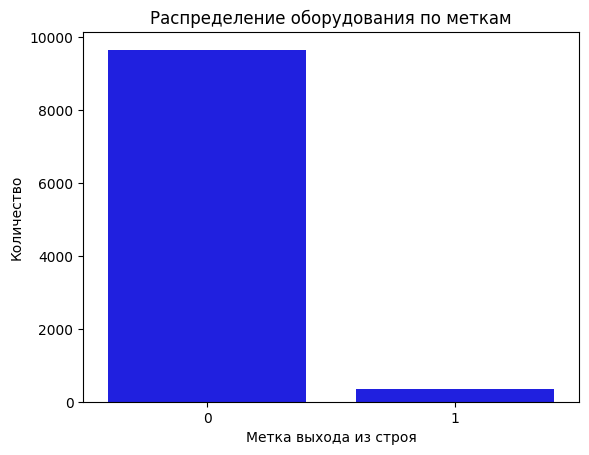

In [ ]:
sns.barplot(
    x='failure',
    y='quantity',
    data=df_count_failure,
    color='blue',)
plt.xlabel('Метка выхода из строя')
plt.ylabel('Количество')
plt.title('Распределение оборудования по меткам')
plt.show()

Из диаграммы видно что данные сильно не сбалансированы (9661 и 339), соответственно при создании и обучении модели их необходимо сбалансировать.

Также построим диаграмму распределения причин отказа оборудования

In [ ]:
df_status_failure = pd.DataFrame(columns=['failure_mode', 'quantity']) # создаём новый датафрейм
df_status_failure['failure_mode'] = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
# Рассчитаем количество отказов оборудования по причинам
df_status_failure['quantity'] = df_status_failure['failure_mode'].apply(lambda x: df_mainteance[(df_mainteance[x] == 1)].shape[0])
df_status_failure.head()

,failure_mode,quantity
0,TWF,46
1,HDF,115
2,PWF,95
3,OSF,98
4,RNF,19


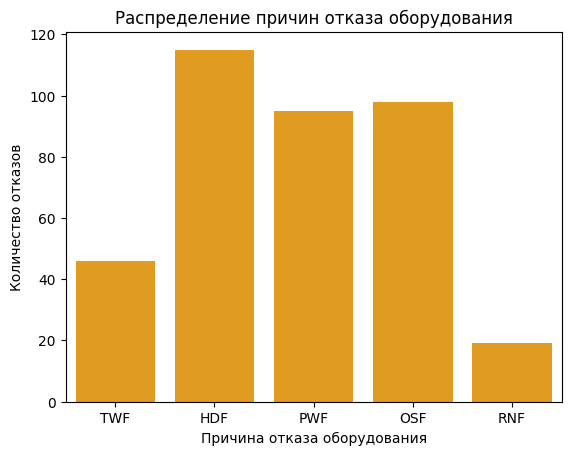

In [ ]:
sns.barplot(
    x='failure_mode',
    y='quantity',
    data=df_status_failure,
    color='orange',)
plt.xlabel('Причина отказа оборудования')
plt.ylabel('Количество отказов')
plt.title('Распределение причин отказа оборудования')
plt.show()

Из диаграммы видно, что самая частая причина отказа оборудования это HDF - из-за рассеивания тепла, на втором месте OSF - от перенапряжения, на третьем  месте PWF - отказ питания, на четвёртом месте TWF - из-за износа инструмента, а на последнем месте RNF - cлучайный отказ.

### Определение признаков и меток

Признаками, в данном случае являются все столбцы в файле, исключая первый (UDI), второй (Product ID) и третий (Type), и последние пять столбцов (TWF, HDF, PWF, OSF, RNF), так как это расшифровка причин отказа.

Столбец с метками это 'Machine failure': 0 (оборудование исправно) или 1 (отказ оборудования).

In [ ]:
X = df_mainteance[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']] # выбираем нужные столбцы - признаки
y = df_mainteance['Machine failure'] # выбираем только столбец Machine failure - метки

При помощи train_test_split из модуля model_selection библиотеки scikit-learn разделяем массивы «X» и «y» на тренировочные и тестовые наборы данных (в данном случае 20% от общего объема).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

Проведём процесс балансировки данных, для этого воспользуемся методом увеличения выборки - Oversampling.

In [ ]:
from imblearn.over_sampling import SMOTE

oversampler = SMOTE()
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)
X_resampled.columns = X_resampled.columns.str.replace(' ', '_').str.replace('[', '_').str.replace(']', '_')
X_test.columns = X_test.columns.str.replace(' ', '_').str.replace('[', '_').str.replace(']', '_')

### Создание и обучение модели

In [ ]:
!pip install --upgrade xgboost # установка библиотеки XGBoost

In [ ]:
import xgboost as xgb

class_model = xgb.XGBClassifier(eta = 0.01,
                                     colsample_bylevel = 0.7,
                                     colsample_bytree = 0.9,
                                     learning_rate = 0.6,
                                     subsample=0.5,
                                     seed = 15)

class_model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.6, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Предсказание категорий для тестовых данных
class_model_pred = class_model.predict(X_test)
# Оценка точности модели
print(f"Точность модели: {accuracy_score(y_test, class_model_pred):.2f}")

Точность модели: 0.96


In [ ]:
print("Точность с разбивкой по меткам :")
print("---------------------------")
label_accs = {}
unique_labels = y_test.unique()

for label in unique_labels:
  label_ind = (y_test == label)
  # extract predictions for specific true label
  pred_label = class_model.predict(X_test[label_ind])
  labels = y_test[label_ind]
  # compute class-wise accuracy
  label_accs[accuracy_score(labels, pred_label)] = label
for key in sorted(label_accs):
  print(f"Метка {label_accs[key]}: {key:.3f}")

Точность с разбивкой по меткам :
---------------------------
Метка 1: 0.857
Метка 0: 0.963


Видно, что модель распознаёт оборудование вышедшее из строя в 85,7% случаев, гораздо лучше модель определяет исправно работающее оборудование - 96,3 % точности.

Построим кривую ROC, а также рассчитаем показатель AUC для оценки производительности модели.

In [ ]:
# предсказание вероятностей
y_pred_proba = class_model.predict_proba(X_test)[:, 1]

# расчитываем TPR и FPR, используя функцию roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_Class_ML_1 = roc_auc_score(y_test, y_pred_proba)

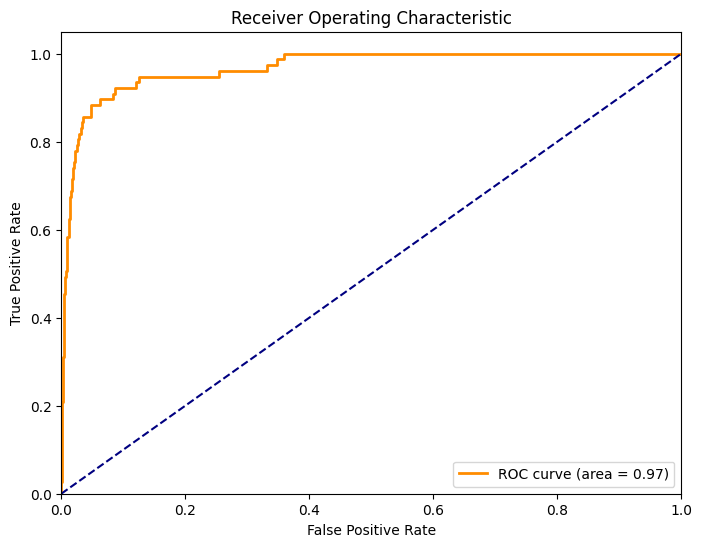

In [ ]:
# построение ROC кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_Class_ML_1)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

Из построенного графика видно хорошую производительность модели - 97%.

Построим матрицу ошибок и оценим качество классификации:

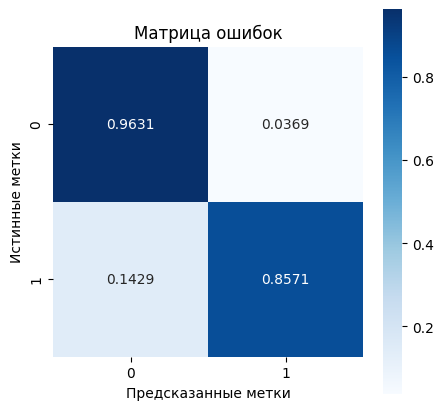

In [ ]:
def show_confusion_matrix(test_labels, test_classes):
  # Вычисление матрицы ошибок и ее нормализация
  plt.figure(figsize=(5,5))
  confusion = confusion_matrix(test_labels, test_classes)
  confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
  axis_labels = unique_labels
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title("Матрица ошибок")
  plt.ylabel("Истинные метки")
  plt.xlabel("Предсказанные метки")

show_confusion_matrix(y_test, class_model_pred)

ВЫВОД: модель неплохо справляется с определением оборудования вышедшего из строя в 85,7% случаев, исправно работающее оборудование модель определяет отлично - 96,3% точности.